# Fine-tuning models with the kluster.ai API

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kluster-ai/klusterai-cookbook/blob/main/examples/finetuning-sent-analysis.ipynb)

## Introduction

Fine-tuning is the process of customizing an existing model using new data to improve performance on a specific task. Fine-tuning can offer valuable benefits: it can significantly improve performance for your specific use case and sometimes rival the results of more expensive, general-purpose models.

This tutorial runs through a notebook where you'll learn how to train a sentiment analysis model tailored to your data using <a href="https://kluster.ai/" target="_blank">kluster.ai</a>. We'll walk through each step of the fine-tuning process, covering dataset setup, environment configuration, and batch inference. 

The example uses a dataset containing various financial news headlines, labeled positive, negative, or neutral regarding the beneficial impact of a company's stock.

By following along, you'll discover how to leverage kluster.ai's powerful platform to create a custom model that boosts accuracy for financial text analysis and beyond.


For a video version of this tutorial, see the YouTube video below.

<style>.embed-container { position: relative; padding-bottom: 56.25%; height: 0; overflow: hidden; max-width: 100%; } .embed-container iframe, .embed-container object, .embed-container embed { position: absolute; top: 0; left: 0; width: 100%; height: 100%; }</style>
<div class="embed-container">
<iframe width="560" height="315" src="https://www.youtube.com/embed/k5ziNToxPz8?si=6Ye4VWzhnarArAJu" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>
</div>
<style>.caption { font-family: Open Sans, sans-serif; font-size: 0.9em; color: rgba(170, 170, 170, 1); font-style: italic; letter-spacing: 0px; position: relative;}</style>

## Prerequisites

Before getting started, ensure you have the following:

- **A kluster.ai account** - sign up on the <a href="https://platform.kluster.ai/signup" target="_blank">kluster.ai platform</a> if you don't have one
- **A kluster.ai API key** - after signing in, go to the <a href="https://platform.kluster.ai/apikeys" target="_blank">**API Keys**</a> section and create a new key. For detailed instructions, check out the <a href="/get-started/get-api-key/" target="_blank">Get an API key</a> guide

## Setup

In this notebook, we'll use Python's `getpass` module to input the key safely. After execution, please provide your unique kluster.ai API key (ensure no spaces).

In [1]:
from getpass import getpass

api_key = getpass("Enter your kluster.ai API key: ")

Enter your kluster.ai API key:  ········


Next, ensure you've installed OpenAI Python and `scikit-learn` libraries. `scikit-learn` is used to split data for training/testing purposes:

In [2]:
%pip install -q openai scikit-learn

Note: you may need to restart the kernel to use updated packages.


With the OpenAI Python library installed, we import the necessary dependencies for the tutorial:

In [3]:
import urllib.request
import pandas as pd
from openai import OpenAI
import time
import json
import matplotlib.pyplot as plt
import os
import requests
from IPython.display import clear_output, display
pd.set_option('display.max_columns', 1000, 'display.width', 1000, 'display.max_rows',1000, 'display.max_colwidth', 500)


And then, initialize the `client` by pointing it to the kluster.ai endpoint, and passing your API key.

In [4]:
# Set up the client
client = OpenAI(
    base_url="https://api.kluster.ai/v1",
    api_key=api_key,
)

## Get the data

This dataset contains a variety of financial news headlines, each labeled as positive, negative, or neutral. In this context, positive indicates a beneficial impact on the company’s stock, negative suggests a detrimental impact, and neutral implies no significant change is expected.

This example provides a dataset of 4846 labeled financial headlines. For a faster-running example, we will select only a portion of the data, though this will impact the effectiveness of the fine-tuning process. The kluster.ai platform requires a minimum of 10 examples.

The data will be split 30%-70%, with 30% used for training and 70% for verification (to help with speed as well).

In [5]:
url = "https://raw.githubusercontent.com/kluster-ai/klusterai-cookbook/main/data/financial-phrasebank.csv"
urllib.request.urlretrieve(url,filename='financial-phrasebank.csv')

# Load and process the dataset based on URL content
df = pd.read_csv('financial-phrasebank.csv', encoding = "ISO-8859-1",header=None, names=["sentiment", "text"])

# For a faster running example, adjust the variable below to select a smaller subset of financial training content
df = df.iloc[:1500]
df.head(3)

,sentiment,text
0,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said ."
2,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported ."


### Split data into train/test for fine-tuning

Next, let's split the data into training and testing datasets (to be used later). In this example, 70% of the data points are used for training, while only 30% for testing the model after fine-tuning it.

In [6]:
from sklearn.model_selection import train_test_split
# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.7, random_state=42)

In [7]:
print("The amount of data points for training:", len(train_df))
print("The amount of data points for testing:", len(test_df))
print("Total data points:", len(train_df) + len(test_df))

The amount of data points for training: 450
The amount of data points for testing: 1050
Total data points: 1500


## Fine-tuning the model

Fine-tuning is adjusting a pre-trained model with new, domain-specific data to enhance performance for a specific task. This typically reduces training time and costs compared to training from scratch. It can allow smaller, fine-tuned models to match or rival the performance of larger, general models that haven’t been fine-tuned.

To fine-tune a model, we'll take the following steps:

1. **Create the training data file** - we'll generate a JSON lines file with the training data that contains the data and ground truth
2. **Upload the training data file** - once it is ready, we'll upload it to the <a href="https://platform.kluster.ai/signup" target="_blank">kluster.ai platform</a> using the API, where it will be processed. We'll receive a unique ID associated with our file
3. **Create fine-tuning job** - after the file is uploaded, we'll initiate the fine-tuning job, using the file ID obtained before
4. **Monitor job progress** - (optional) track the status of the fine-tuning job to ensure it has been successfully completed
5. **Retrieve results** - once the job has completed execution, we will get a fine-tuned model that we can use

This notebook is prepared for you to follow along. Run the cells below to watch it all come together.

### Create the training data file

This example uses `klusterai/Meta-Llama-3.1-8B-Instruct-Turbo` as the model to fine-tune. We will later compare the fine-tuned model against the larger `klusterai/Meta-Llama-3.3-70B-Instruct-Turbo` model to see how it performs.

Please refer to the <a href="/get-started/models/" target="_blank">Supported models</a> section for a list of the models we support for fine-tuning.

The following snippets prepare the JSONL file, where each line represents a different training data point.

In [8]:
SYSTEM_PROMPT = '''
    You are a helpful assistant specializing in determining the sentiment of financial news.
    Analyze the following text regarding financial information and assign one of the following labels to indicate its sentiment: positive, negative, or neutral.
    Provide your response as a single word without any punctuation.
    '''

# Ensure the directory exists
os.makedirs("fine_tuning", exist_ok=True)

# Create the messages file with the prompt, content, and sentiment for training
def create_messages_file(train_df):
    messages_list = []
    for index, row in train_df.iterrows():
        content = row['text']
        sentiment = row['sentiment']

        # Create the message structure
        messages = {
                "messages": [
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user", "content": content},
                    {"role": "assistant", "content": sentiment}
                ],
            }
        
        messages_list.append(messages)
        
    return messages_list

# Save file
def save_messages_file(messages_list):
    filename = f"fine_tuning/request.jsonl"
    with open(filename, 'w') as file:
        for messages in messages_list:
            file.write(json.dumps(messages) + '\n')
    return filename

Let's run the functions to create the messages file:

In [9]:
messages_list = create_messages_file(train_df)
data_dir = save_messages_file(messages_list)
print(data_dir)

fine_tuning/request.jsonl


Next, let's preview the fine-tuning file:

In [10]:
!head -n 3 fine_tuning/request.jsonl\

{"messages": [{"role": "system", "content": "\n    You are a helpful assistant specializing in determining the sentiment of financial news.\n    Analyze the following text regarding financial information and assign one of the following labels to indicate its sentiment: positive, negative, or neutral.\n    Provide your response as a single word without any punctuation.\n    "}, {"role": "user", "content": "However , Simdax will remain available in the markets where it already has been approved as it has marketing authorisations or submitted applications in more than 40 countries , Orion added ."}, {"role": "assistant", "content": "positive"}]}
{"messages": [{"role": "system", "content": "\n    You are a helpful assistant specializing in determining the sentiment of financial news.\n    Analyze the following text regarding financial information and assign one of the following labels to indicate its sentiment: positive, negative, or neutral.\n    Provide your response as a single word wit

### Upload fine-tuning file to kluster.ai

Now that we've prepared our fine-tuning file, it's time to upload it to the kluster.ai platform. To do so, you can use the `files.create` endpoint of the client, where the purpose is set to `fine-tune`. This will return the file ID, which we need to log for the next steps.

In [11]:
# Upload fine-tuning file
with open(data_dir, 'rb') as file:
    upload_response = client.files.create(
        file=file,
        purpose="fine-tune"
    )

    # Print job ID
    file_id = upload_response.id
    print(f"File uploaded successfully. File ID: {file_id}")


File uploaded successfully. File ID: 682388549bf57c3b70e5b99e


### Start the fine-tuning 

Once the fine-tuning file has been successfully uploaded, we're ready to start the fine-tuning job by providing the file ID we got in the previous step. To do so, we use the `fine_tuning.jobs.create` method, for which we also need to provide the model to fine-tune (check the <a href="/get-started/models/" target="_blank">Supported models</a> section). 

Optionally, you can also provide an object containing the <a href="/api-reference/reference/#create-a-fine-tuning-job" target="_blank">hyperparameters for fine-tuning</a>, such as number of epochs, batch size, and learning rate, to adjust training time and potential performance gains. Remember that increasing the number of epochs will lead to longer training time but may result in higher performance. If you're unsure which hyperparameters to set, you can also comment them to accept the default values.

In [12]:
# Model
model = "klusterai/Meta-Llama-3.1-8B-Instruct-Turbo"

# Create fine-tune job with the previous file
fine_tuning_job = client.fine_tuning.jobs.create(
    training_file=file_id,
    model=model,
    #hyperparameters={
    #  "batch_size": 3,
    #  "n_epochs": 2,
    #  "learning_rate_multiplier": 0.08
    #}
)
print("\nFine-tuning job created:")
fine_tuning_job_dict = fine_tuning_job.model_dump()
print(json.dumps(fine_tuning_job_dict, indent=2))


Fine-tuning job created:
{
  "id": "68243f089a7eb57869c060de",
  "created_at": 1747205896,
  "error": null,
  "fine_tuned_model": null,
  "finished_at": null,
  "hyperparameters": {
    "batch_size": 1,
    "learning_rate_multiplier": 1.0,
    "n_epochs": 10
  },
  "model": "meta-llama/Llama-3.1-8B-Instruct",
  "object": "fine_tuning.job",
  "organization_id": null,
  "result_files": [],
  "seed": null,
  "status": "queued",
  "trained_tokens": null,
  "training_file": "682388549bf57c3b70e5b99e",
  "validation_file": null,
  "estimated_finish": null,
  "integrations": [],
  "metadata": null,
  "method": {
    "dpo": null,
    "supervised": {
      "hyperparameters": null,
      "batch_size": 1,
      "learning_rate_multiplier": 1,
      "n_epochs": 10
    },
    "type": "supervised"
  },
  "labels": [],
  "metrics": {}
}


### Check job progress and fine-tuned model

Now that your fine-tuning job has been created, you can track its progress.

To monitor the job's progress, use the `fine_tuning.jobs.retrieve` method and pass the fine-tuning job ID. The response contains a `status` field that tells us if it is completed or not, and the subsequent status of each job separately.

The following snippet checks the status every 10 seconds until the entire batch is completed:

In [13]:
def monitor_fine_tuning_job(fine_tuning_job):
    all_completed = False

    # Loop until all jobs are completed
    while not all_completed:
        all_completed = True
        output_lines = []

        # Loop through all batch jobs
        updated_job = client.fine_tuning.jobs.retrieve(fine_tuning_job.id)
        status = updated_job.status

        # If job is completed
        if status == "succeeded":
            output_lines.append("Job completed!")

        # If job failed, cancelled or expired
        elif status in ["failed", "cancelled"]:
            output_lines.append(f"Job ended with status: {status}")
            break

        # If job is ongoing
        else:
            all_completed = False
            output_lines.append(f"Job status: {status}")

        # Clear terminal
        clear_output(wait=True)
        for line in output_lines:
            display(line)

        # Check every 10 seconds
        if not all_completed:
            time.sleep(10)


In [14]:
monitor_fine_tuning_job(fine_tuning_job)

'Job completed!'

### Retrieve fine-tuned model

With the fine-tuning job done, we can retrieve the new fine-tuned model name:

In [15]:
finished_job = client.fine_tuning.jobs.retrieve(fine_tuning_job.id)
fine_tuned_model = finished_job.fine_tuned_model
print(fine_tuned_model)


ft:meta-llama:Llama-3.1-8B-Instruct:personal:0ee22019


Congratulations! You've now created a fine-tuned model. The exact name of your fine-tuned model is above.

Now you can submit <a href="/get-started/start-building/real-time/" target="_blank">real-time</a>
 or <a href="/get-started/start-building/batch/" target="_blank">batch</a> inference by providing your fine-tuned model's name as the `model` for the inference call.

In the next section, we will perform batch inference against the testing data points and compare the accuracy against a larger model.

## Test the fine-tuned model with batch inference

In this section, we’ll run batch requests to the fine-tuned and baseline models, using the data points left over for testing.

For the batch inference, we will follow a similar pipeline to that of the <a href="/tutorials/klusterai-api/model-comparison/#perform-batch-inference" target="_blank">model comparison notebook</a>.

### Create batch job file

The following snippets prepare the JSONL file, where each line represents a different request. Note that each separate batch request can have its own model. In our example, we create a separate JSONL file for each model. Also, we are using a temperature of `0.5`, but feel free to change it and play around with the different outcomes (but we are only asking to respond with a single word, the sentiment).

In [16]:
# System prompt
SYSTEM_PROMPT = """
    You are a helpful assistant specializing in determining the sentiment of financial news.
    Analyze the following text regarding financial information and assign one of the following labels to indicate its sentiment: positive, negative, or neutral.
    Provide your response as a single lowercase word without any punctuation.
    Example response:
    neutral
    """

# Models
models = {
    "Llama3.1-8B": "klusterai/Meta-Llama-3.1-8B-Instruct-Turbo",
    "Llama3.3-70B": "klusterai/Meta-Llama-3.3-70B-Instruct-Turbo",
    "Llama3.1-8B-FineTuned": fine_tuned_model,
}

# Ensure the directory exists
os.makedirs("fine_tuning", exist_ok=True)

# Create the batch job file with the prompt and content for the model
def create_batch_file(model):
    batch_requests = []
    
    for index, row in test_df.iterrows():
        content = row["text"]

        request = {
            "custom_id": f"{model}-{index}-fine-tuning-compare",
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": models[model],
                "temperature": 0,
                "messages": [
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user", "content": content},
                ],
            },
        }
        
        batch_requests.append(request)

    return batch_requests

# Save file
def save_batch_file(batch_requests, model):
    filename = f"fine_tuning/batch_job_{model}_request.jsonl"
    with open(filename, "w") as file:
        for request in batch_requests:
            file.write(json.dumps(request) + "\n")
    return filename


Let's run the functions we've defined before:

In [17]:
filenames = []

# Loop through each model and save the batch files
for model in models:
    batch_request = create_batch_file(model)
    filename = save_batch_file(batch_request, model)
    filenames.append(filename)
    print(filename)


fine_tuning/batch_job_Llama3.1-8B_request.jsonl
fine_tuning/batch_job_Llama3.3-70B_request.jsonl
fine_tuning/batch_job_Llama3.1-8B-FineTuned_request.jsonl


Next, we can preview what one of the requests in a batch job file looks like:

In [18]:
!head -n 1 fine_tuning/batch_job_Llama3.1-8B-FineTuned_request.jsonl

{"custom_id": "Llama3.1-8B-FineTuned-1116-fine-tuning-compare", "method": "POST", "url": "/v1/chat/completions", "body": {"model": "ft:meta-llama:Llama-3.1-8B-Instruct:personal:0ee22019", "temperature": 0, "messages": [{"role": "system", "content": "\n    You are a helpful assistant specializing in determining the sentiment of financial news.\n    Analyze the following text regarding financial information and assign one of the following labels to indicate its sentiment: positive, negative, or neutral.\n    Provide your response as a single lowercase word without any punctuation.\n    Example response:\n    neutral\n    "}, {"role": "user", "content": "Welcome !"}]}}


### Upload batch job file to kluster.ai

Now that we've prepared our input files, it's time to upload them to the kluster.ai platform. To do so, you can use the `files.create` endpoint of the client, where the purpose is set to `batch`. This will return the file ID, which we need to log for the next steps. We will repeat the process for each batch file created.

In [19]:
def upload_batch_file(data_dir):
  print(f"Creating request for {data_dir}")
  
  with open(data_dir, 'rb') as file:
    upload_response = client.files.create(
    file=file,
    purpose="batch"
  )

  # Print job ID
  file_id = upload_response.id
  print(f"File uploaded successfully. File ID: {file_id}")

  return upload_response

In [20]:
batch_files = []

# Loop through all .jsonl files in the data folder
for data_dir in filenames:
    print(f"Uploading file {data_dir}")
    job = upload_batch_file(data_dir)
    batch_files.append(job)

Uploading file fine_tuning/batch_job_Llama3.1-8B_request.jsonl
Creating request for fine_tuning/batch_job_Llama3.1-8B_request.jsonl
File uploaded successfully. File ID: 68246ad350145e585380f774
Uploading file fine_tuning/batch_job_Llama3.3-70B_request.jsonl
Creating request for fine_tuning/batch_job_Llama3.3-70B_request.jsonl
File uploaded successfully. File ID: 68246ad48f1e3a990c42a706
Uploading file fine_tuning/batch_job_Llama3.1-8B-FineTuned_request.jsonl
Creating request for fine_tuning/batch_job_Llama3.1-8B-FineTuned_request.jsonl
File uploaded successfully. File ID: 68246ad434dfea3753a0d37b


### Start the job

Once all the files have been successfully uploaded, we're ready to start (create) the batch jobs by providing the file ID of each file, which we got in the previous step. To start each job, we use the `batches.create` method, for which we need to set the endpoint to `/v1/chat/completions`. This will return each batch job's details, with each ID.

In [21]:
# Create batch job with completions endpoint
def create_batch_job(file_id):
  batch_job = client.batches.create(
    input_file_id=file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h"
  )

  print(f"Batch job created with ID {batch_job.id}")
  return batch_job

In [22]:
batch_jobs = []

# Loop through all batch files ID and start each job
for batch_file in batch_files:
    print(f"Creating batch job for file ID {batch_file.id}")
    batch_job = create_batch_job(batch_file.id)
    batch_jobs.append(batch_job)

Creating batch job for file ID 68246ad350145e585380f774
Batch job created with ID 68246ad73c4615f4a676b4a3
Creating batch job for file ID 68246ad48f1e3a990c42a706
Batch job created with ID 68246ad762b0d0b72df059a6
Creating batch job for file ID 68246ad434dfea3753a0d37b
Batch job created with ID 68246ad7d7f7bb800aa63c9d


### Check job progress

Now that your batch jobs have been created, you can track their progress.

To monitor the job's progress, we can use the `batches.retrieve` method and pass the batch job ID. The response contains a `status` field that tells whether it is completed and the subsequent status of each job separately. We can repeat this process for every batch job ID we get in the previous step.

The following snippet checks the status of all batch jobs every 10 seconds until the entire batch is completed.

In [23]:
def monitor_batch_jobs(batch_jobs):
    all_completed = False

    # Loop until all jobs are completed
    while not all_completed:
        all_completed = True
        output_lines = []

        # Loop through all batch jobs
        for job in batch_jobs:
            updated_job = client.batches.retrieve(job.id)
            status = updated_job.status

            # If job is completed
            if status == "completed":
                output_lines.append("Job completed!")
            # If job failed, cancelled or expired
            elif status in ["failed", "cancelled", "expired"]:
                output_lines.append(f"Job ended with status: {status}")
                break
            # If job is ongoing
            else:
                all_completed = False
                completed = updated_job.request_counts.completed
                total = updated_job.request_counts.total
                output_lines.append(
                    f"Job status: {status} - Progress: {completed}/{total}"
                )

        # Clear terminal
        clear_output(wait=True)
        for line in output_lines:
            display(line)

        # Check every 10 seconds
        if not all_completed:
            time.sleep(10)


In [24]:
monitor_batch_jobs(batch_jobs)

'Job completed!'

'Job completed!'

'Job completed!'

## Get the results

With all jobs completed, we'll retrieve the results and review the responses generated for each request. The results are parsed. To fetch the results from the platform, you must retrieve the `output_file_id` from the batch job and then use the `files.content` endpoint, providing that specific file ID. We will repeat this for every single batch job id. Note that the job status must be `completed` to retrieve the results!

In [25]:
#Parse results as a JSON object
def parse_json_objects(data_string):
  if isinstance(data_string, bytes):
    data_string = data_string.decode('utf-8')

  json_strings = data_string.strip().split('\n')
  json_objects = []

  for json_str in json_strings:
    try:
      json_obj = json.loads(json_str)
      json_objects.append(json_obj)
    except json.JSONDecodeError as e:
      print(f"Error parsing JSON: {e}")

  return json_objects

In [26]:
# Token usage per model
token_usage = {}

# Pricing at the time of writing
pricing = {
    "Llama3.1-8B": {"input": 0.18, "output": 18},
    "Llama3.3-70B": {"input": 0.70, "output": 0.70},
    "Llama3.1-8B-FineTuned": {"input": 0.18, "output": 18},
}

# Go through all batch jobs, providing the output file ID
for batch_job in batch_jobs:
    job_status = client.batches.retrieve(batch_job.id)
    result_file_id = job_status.output_file_id
    result = client.files.content(result_file_id).content
    results = parse_json_objects(result)

    # Extract model name from the response
    model_path = results[0]['response']['body']['model']
    model = next(k for k, v in models.items() if v == model_path)

    # Initialize counters for this model
    total_prompt_tokens = 0
    total_completion_tokens = 0

    answers = []
    for res in results:
        # Get answer
        answer = res['response']['body']['choices'][0]['message']['content']
        answers.append(answer)

        # Accumulate tokens
        usage = res['response']['body']['usage']
        total_prompt_tokens += usage.get('prompt_tokens', 0)
        total_completion_tokens += usage.get('completion_tokens', 0)

    # Save answers to DataFrame
    test_df[f'{model}_sentiment'] = answers

    # Calculate cost (per million tokens)
    input_price = pricing[model]['input']
    output_price = pricing[model]['output']
    cost = (total_prompt_tokens / 1_000_000) * input_price + (total_completion_tokens / 1_000_000) * output_price

    # Store token and cost data
    token_usage[model] = {
        'total_prompt_tokens': total_prompt_tokens,
        'total_completion_tokens': total_completion_tokens,
        'total_cost_usd': round(cost, 4)
    }


## Analyze the results

With all models evaluated, we can analyze their performance. The graph below shows the accuracy scores for each model we tested. 

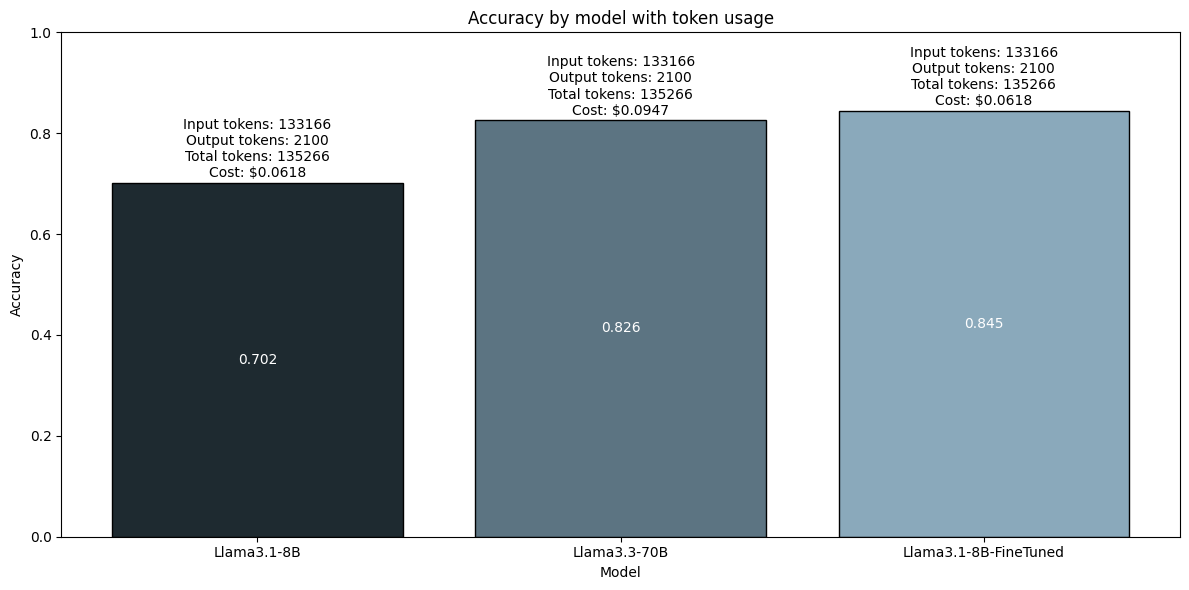

In [27]:
# Calculate accuracy
accuracies = {}
for model in models:
    accuracy = test_df.apply(
    lambda row: row[f'{model}_sentiment'].lower() in [s.lower() for s in row['sentiment'].split(', ')], axis=1).mean()
    accuracies[model] = accuracy

# Plot colors
colors = ['#1E2A30', '#5C7482', '#8AA9BB']

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(accuracies.keys(), accuracies.values(), color=colors, edgecolor='black')
ax.bar_label(bars, label_type='center', color='white', fmt="%.3f")

# Add token usage as text above bars
for bar, model in zip(bars, accuracies.keys()):
    prompt_tokens = token_usage[model]['total_prompt_tokens']
    completion_tokens = token_usage[model]['total_completion_tokens']
    cost = token_usage[model]['total_cost_usd']

    # Positioning text above the bar
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        f"Input tokens: {prompt_tokens}\nOutput tokens: {completion_tokens}\nTotal tokens: {prompt_tokens+completion_tokens}\nCost: ${cost}",
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# Labels and title
ax.set_ylim(0, 1)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by model with token usage')

plt.tight_layout()
plt.show()

The analysis shows that the fine-tuned model achieved a higher accuracy at a significantly lower cost than the larger base model. The accuracy was also substantially higher compared to the same base model.

This demonstrates how a fine-tuned model can deliver better task-specific performance while being more efficient in computation and cost. Instead of relying on a much larger, general-purpose model, fine-tuning enables smaller models to adapt closely to the nuances of your data, making them more accurate, faster to run, and more affordable to scale.

This benefit is especially impactful in the context of financial sentiment analysis, where language can be technical and domain-specific. Even with a modest training dataset, the improvement in precision and reduction in cost were substantial.


## Summary

This tutorial showed how to fine-tune a large language model using the kluster.ai platform for a financial sentiment analysis task. Key takeaways include:

- Data preparation: a subset of 1500 financial headlines was used, split into training and testing sets
- Fine-tuning: we fine-tuned `klusterai/Meta-Llama-3.1-8B-Instruct-Turbo` using labeled training data and system prompts for targeted learning
- Batch inference & evaluation: we compared the fine-tuned model with a much larger base model (`Llama3.3-70B`) and the original untuned `Llama3.1-8B`
- Performance: the fine-tuned model delivered **higher accuracy** than the untuned 8B model, and surprisingly, **outperformed** the 70B model — all at **lower inference cost**. Note that the results may vary depending on the fine-tuning hyperparameters, temperature, among others

This reinforces the value of fine-tuning for domain-specific tasks: improved performance, reduced cost, and faster inference. Moreover, with kluster.ai, we achieved all this using the OpenAI Python library and API, no changes needed!

You are now ready to experiment further with:
- Larger or more diverse datasets
- Hyperparameter tuning
- Alternate system prompts or evaluation metrics

Fine-tuning doesn't just make your model better — it makes it *yours*.
